# Capstone Project - Amazon Review Analysis

For my Capstone project for the DSI Immersive Program at General Assembly I am going to attempt to predict whether or not an Amazon review gave a 5-star rating based solely off of the text and summary of the review. I will be implementing several different Natural Language Processing techniques in order to do this. Along the way I will also look at what words or sets of words are best for for this prediction, which should have a great business-use of showing what features of a product customers are looking for.

### Fetching Data

All of the Amazon review data can be found here: http://jmcauley.ucsd.edu/data/amazon/

I will be using only the Electronics subsection, as I believe that this is the section where I have the most domain knowledge, while still being an extremely sizable dataset at ~1.6million entries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
import gzip

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [4]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("/Users/stephenhockey/Downloads/reviews_Electronics_5.json.gz")

df.shape

(1689188, 9)

Because we are solely using Natural Language Processing for this prediction, and we have a very large dataset of more than 1.6 million reviews, I will cut this down by removing all entries with the text of the review being less than 100 characters, and all entries with the summary of the review being less than 5 characters (pretty much just getting rid of reviews with empty or useless summaries).

In [5]:
df = df[df.reviewText.apply(lambda x: len(x) >= 100) == True]
df.shape

(1648246, 9)

In [6]:
all_text = df.loc[df['overall'] == 5].reviewText.copy()
new_text = all_text.str.cat(sep=' ')

In [22]:
all_text_not5or4 = df.loc[df['overall'] != 5 | 4].reviewText.copy()
new_text_not5or4 = all_text_not5or4.str.cat(sep=' ')

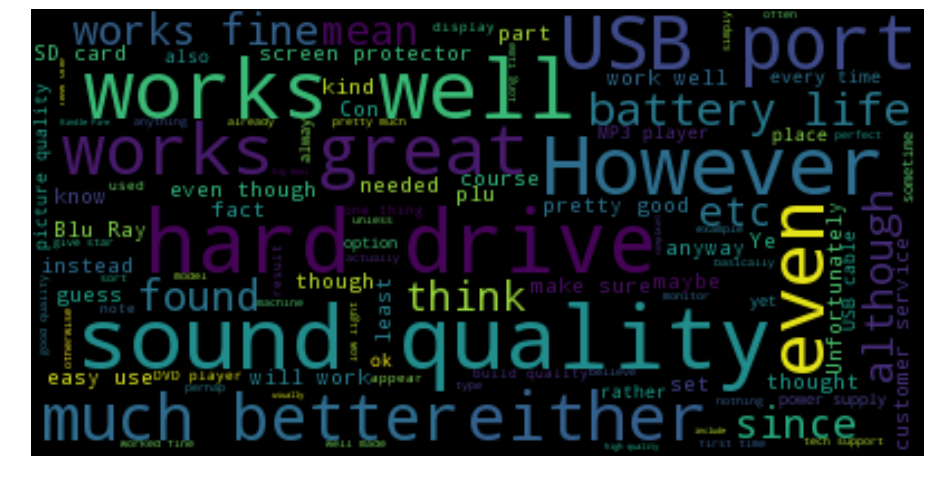

In [23]:
text = new_text_not5or4

stopwords = set(STOPWORDS)
stopwords.add("said")

wordcloud = WordCloud(max_words=100, max_font_size=40, stopwords=stopwords)
wordcloud.generate(text)

# show
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

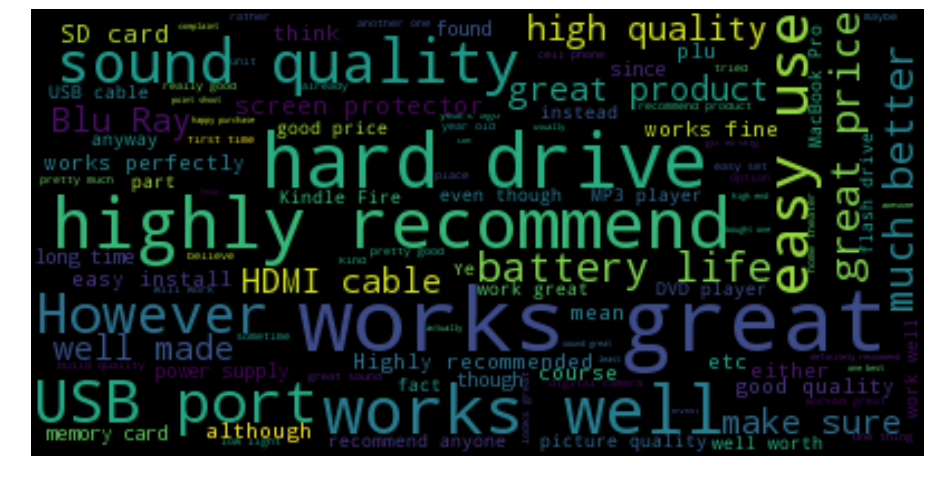

In [12]:
text = new_text

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(max_words=100, max_font_size=40, stopwords=stopwords)
wc.generate(text)

# show
plt.figure(figsize=(16,16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
from string import punctuation

In [25]:
# From some later investigation it seems that there are some reviews with summaries longer than
# 5 characters that consist solely of white space or punctuation. To also remove these we will 
# strip all white space and punctuation from the summary before counting the length.

def remove_spaces_and_punctuation(text):
    text = text.replace(' ', '')
    text = text.translate(str.maketrans('', '', punctuation))
    return text

dfcopy = df.copy()
dfcopy.summary = dfcopy.summary.apply(remove_spaces_and_punctuation)
df = df[dfcopy.summary.apply(lambda x: len(x) >= 5)]

# reseting the index so there are not numbers skipped 
df.index = range(df.shape[0])
df.shape

(1621241, 9)

In [26]:
df.index = range(df.shape[0])

It does not seem like there were very many reviews with a text length of less than 100 characters or a summary of less than 5 characters, as only about 60,000 of the entries were dropped.

### Initial Look at Data

In [27]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [28]:
df.isnull().sum()

reviewerID            0
asin                  0
reviewerName      22897
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64

The only column with any null values is 'reviewerName', which we will not be using to predict the rating anyways.

In [29]:
df['overall'].value_counts()

5.0    966299
4.0    335482
3.0    136141
1.0    103846
2.0     79473
Name: overall, dtype: int64

In [30]:
df['overall'].value_counts().sort_index().values.tolist()

[103846, 79473, 136141, 335482, 966299]

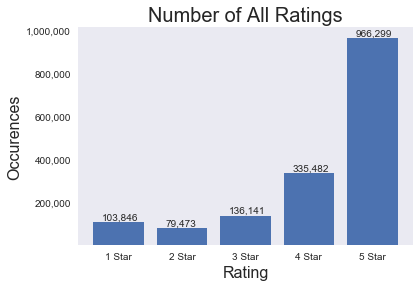

In [102]:
bars = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['103,846', '79,473', '136,141', '335,482', '966,299']
values = df.overall.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)
for i in range(5):
    plt.text(x=bars[i]-0.26, y=values[i]+11000, s=labels[i])
plt.title('Number of All Ratings', fontsize=20)
plt.grid(False)
plt.show()

In [97]:
target.value_counts()

1    966299
0    654942
Name: overall, dtype: int64

In [98]:
multiclass_target.value_counts()

2    966299
1    335482
0    319460
Name: overall, dtype: int64

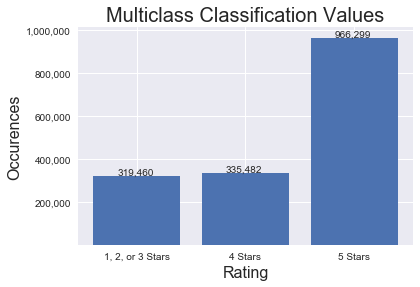

In [99]:
bars = [0, 1, 2]
labels = ['319,460', '335,482', '966,299']
values = multiclass_target.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1, 2, or 3 Stars', '4 Stars', '5 Stars'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)
for i in range(3):
    plt.text(x=bars[i]-0.18, y=values[i]+6000, s=labels[i])
plt.title('Multiclass Classification Values', fontsize=20)
plt.show()

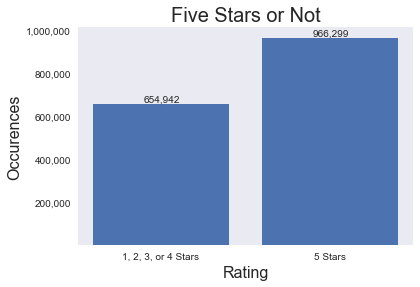

In [105]:
bars = [0, 1]
labels = ['654,942', '966,299']
values = target.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1, 2, 3, or 4 Stars', '5 Stars'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)
for i in range(2):
    plt.text(x=bars[i]-0.1, y=values[i]+11000, s=labels[i])
plt.title('Five Stars or Not', fontsize=20)
plt.grid(False)
plt.show()

In [33]:
# Checking to see our baseline accuracy that we will try to improve on with our model.
baseline = df['overall'].value_counts()[5.0] / df['overall'].value_counts().sum()
print(baseline)

0.596024280166


Because most of the columns in this dataset seem like they will be completely irrelevant to the rating given with the review, the first step is to filter out only the relevant predictor columns, which would be the 'reviewText' and 'summary', and the target column 'overall'. Since we are only interested in predicting whether or not a reviews rating was a 5, we can then change all values that aren't a 5 to a 0 and all 5s to a 1.

In [34]:
target = df['overall'].apply(lambda x: 1 if x == 5.0 else 0)
X = df[['reviewText', 'summary']]

In [35]:
## TO BE FILLED IN LATER - MULTICLASS TARGET, TRYING TO CLASSIFY WHETHER THE RATING IS 5, 4, 
## OR LOWER THAN THAT
multiclass_target = df['overall'].apply(lambda x: 2 if x == 5.0 else 1 if x == 4.0 else 0)

We will then use train_test_split to split up our data into training and testing sets in order to test our model on data it has not seen before.

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=24)

In [38]:
## MULTICLASS TARGET SPLIT - SHOULD ONLY HAVE TO USE THE NEW Y VALUES FROM THIS AS THE Xs
## SHOULD ALL BE THE SAME!
mutliclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = \
                        train_test_split(X, multiclass_target, test_size=0.1, random_state=24)

### Natural Language Processing

In [39]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Since we have two different columns that we will be utilizing Natural Language Processing on, we will need to separate them from both X_train and X_test into their own series. This is so that we have separate values for words contained within both the summary of the review and the text of a review, which should be an important distinction.

In [40]:
# X_train_text = X_train['reviewText']
# X_train_summary = X_train['summary']
# X_test_text = X_test['reviewText']
# X_test_summary = X_test['summary']

In [41]:
# # Creating our text preprocesser. The function will remove punctuation and numbers from the
# # text, change it all into lowercase, and add all words that are not in the english stop-words
# # list to a list of final words, while stemming words with the same roots together.

# def text_preprocesser(text):
#     stemmer = PorterStemmer()
#     stop = stopwords.words('english')
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     text = text.translate(str.maketrans('', '', string.digits))
#     text = text.lower().strip()
#     final_text = []
#     for w in text.split():
#         if w not in stop:
#             final_text.append(stemmer.stem(w.strip()))
#     return ' '.join(final_text)

Because our preprocesser that we will run all of our text through removes all punctuation and case of the text, I will manually create binary classification columns for where the summary and text of a post contains certain punctuation, and a column for the percentage of the text that was upper-case (assuming worse reviews have a higher ratio of capital letters). 

In [42]:
# X_train['reviewText_contains_?'] = X_train_text.str.contains('\?').astype(int)
# X_train['reviewText_contains_!'] = X_train_text.str.contains('!').astype(int)
# X_train['reviewText_contains_!!+'] = X_train_text.str.contains('!!+').astype(int)
# X_train['reviewText_contains_??+'] = X_train_text.str.contains('\?\?+').astype(int)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [43]:
# X_test['reviewText_contains_?'] = X_test_text.str.contains('\?').astype(int)
# X_test['reviewText_contains_!'] = X_test_text.str.contains('!').astype(int)
# X_test['reviewText_contains_!!+'] = X_test_text.str.contains('!!+').astype(int)
# X_test['reviewText_contains_??+'] = X_test_text.str.contains('\?\?+').astype(int)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [44]:
# # Strips the message of punctuation, counts the number of capital letters in the text, then
# # divides that number by the length of the text minus the number of spaces. This makes it so
# # that punctuation and whitespaces are not included in the total length of the message and
# # don't throw off the ratio.
# def capital_ratio(message):
#     message = message.translate(str.maketrans('', '', punctuation))
#     capitals = sum(1 for x in message if x.isupper())
#     total = len(message)
#     spaces = message.count(' ')
#     capital_ratio = capitals / (total - spaces)
#     return capital_ratio

In [45]:
# X_train['reviewText_capital_ratio'] = X_train_text.apply(capital_ratio)
# X_test['reviewText_capital_ratio'] = X_test_text.apply(capital_ratio)
# X_train['summary_capital_ratio'] = X_train_summary.apply(capital_ratio)
# X_test['summary_capital_ratio'] = X_test_summary.apply(capital_ratio)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [46]:
from textblob import TextBlob

In [47]:
# def polarity(text):
#     text = TextBlob(text)
#     return text.sentiment.polarity

In [48]:
# X_train['reviewText_polarity'] = X_train_text.apply(polarity)
# X_test['reviewText_polarity'] = X_test_text.apply(polarity)
# X_train['summary_polarity'] = X_train_summary.apply(polarity)
# X_test['summary_polarity'] = X_test_summary.apply(polarity)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

#### TFIDF Vectorizer

We are now going to run our two text columns through TFIDF Vectorizer to processed columns with values signifying how many times a specific word appears in a document vs. how unique that word is within the entire corpus.

#### reviewText

In [80]:
## COMMENTING OUT BECAUSE KERNEL DIED AND DO NOT WANT TO RUN AGAIN FOR SAKE OF TIME
# text_tfidf = TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.001, max_df=0.6)
# text_tfidf.fit(X_train_text)

# text_tfidf_X_train = text_tfidf.transform(X_train_text)
# text_tfidf_X_test = text_tfidf.transform(X_test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=None, min_df=0.001,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function text_preprocesser at 0x1e442f4510>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

In [106]:
# Looking for combinations of 2-words that are unique between documents
text_2words_tfidf = TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.001, max_df=0.6,
                                   ngram_range=(2,2))
text_2words_tfidf.fit(X_train_text)

text_2words_tfidf_X_train = text_tfidf.transform(X_train_text)
text_2words_tfidf_X_test = text_tfidf.transform(X_test_text)

In [107]:
save_npz('text_2words_tfidf_X_train.npz', text_2words_tfidf_X_train)
save_npz('text_2words_tfidf_X_test.npz', text_2words_tfidf_X_test)

#### Summary

In [81]:
## COMMENTING OUT BECAUSE KERNEL DIED AND DO NOT WANT TO RUN AGAIN FOR SAKE OF TIME
# summary_tfidf = TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.0001, max_df=0.6)
# summary_tfidf.fit(X_train_summary)

# summary_tfidf_X_train = summary_tfidf.transform(X_train_summary)
# summary_tfidf_X_test = summary_tfidf.transform(X_test_summary)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=None, min_df=0.0001,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function text_preprocesser at 0x1e442f4510>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

### Saving My Matrices

Because I am working with NLP on such a large dataset, it takes a very long time to fit and transform it on the TFIDF Vectorizer. I've also killed the kernel more than a couple times by attempting to do operations that I have learned I should not do on such a dataset, such as trying to make my TFIDF output matrices dense. To avoid having to wait for these to fit and transform on future kernel deaths, I will save my sparse matrices locally using them locally using scipy.sparse.save_npz, and load them using scipy.sparse.load_npz.

In [49]:
from scipy.sparse import save_npz, load_npz

In [50]:
# save_npz('text_tfidf_X_train.npz', text_tfidf_X_train)
# save_npz('text_tfidf_X_test.npz', text_tfidf_X_test)
# save_npz('summary_tfidf_X_train.npz', summary_tfidf_X_train)
# save_npz('summary_tfidf_X_test.npz', summary_tfidf_X_test)

In [51]:
text_tfidf_X_train = load_npz('text_tfidf_X_train.npz')
text_tfidf_X_test = load_npz('text_tfidf_X_test.npz')
summary_tfidf_X_train = load_npz('summary_tfidf_X_train.npz')
summary_tfidf_X_test = load_npz('summary_tfidf_X_test.npz')

### Preparation for Modeling

In [52]:
# # We can now safely drop our text columns from both X_train and X_test as they have already
# # been extracted and processed.

# X_train = X_train.drop(['reviewText', 'summary'], axis=1)
# X_test = X_test.drop(['reviewText', 'summary'], axis=1)

We will be working only with sparse matrices for our models. Since the dataset is so large, just trying to convert the sparse matrices output from the TFIDF Vectorizer caused my computer to run out of memory. To avoid this, we will just use sparse matrices which are much more efficient to run as they omit all datapoints with a value of 0, which would be a huge amount when you are using NLP.

However, in order to use sparse matrices for our model, we will need to convert our dataframes X_train and X_test with our created features into sparse matrices, and find out how to concatenate sparse matrices together. We will then do that on our text_tfidf, summary_tfidf, and original dataframe(turned into a sparse matrix) for both our training set and testing set of data. We should then be ready to model, using of course, a model that will accept sparse matrices as an input.

In [53]:
# Just confirming that all of our data is the expected shape so that we won't have any issues
# adding them together.

print('Training:', text_tfidf_X_train.shape, summary_tfidf_X_train.shape, X_train.shape)
print('Testing:', text_tfidf_X_test.shape, summary_tfidf_X_test.shape, X_test.shape)

Training: (1459116, 3322) (1459116, 2178) (1459116, 8)
Testing: (162125, 3322) (162125, 2178) (162125, 8)


In [55]:
# # We can convert dense matrices such as our X_train and X_test into the same format (Compressed
# # Sparse Row) as our tfidf data using csr_matrix from the scipy.sparse library.
# from scipy.sparse import csr_matrix

# sparse_X_train = csr_matrix(X_train)
# sparse_X_test = csr_matrix(X_test)

# # Going to once again save these sparse matrices, to be loaded in case of kernel death
# save_npz('sparse_X_train', sparse_X_train)
# save_npz('sparse_X_test', sparse_X_test)

In [77]:
sparse_X_train = load_npz('sparse_X_train.npz')
sparse_X_test = load_npz('sparse_X_test.npz')

In [117]:
# To concatenate our three separate sparse matrices back into just one sparse matrix, we can
# use hstack, also from the scipy.sparse library.
from scipy.sparse import hstack
modeling_tfidf_X_train = hstack((text_tfidf_X_train, summary_tfidf_X_train, sparse_X_train))
modeling_tfidf_X_test = hstack((text_tfidf_X_test, summary_tfidf_X_test, sparse_X_test))

In [118]:
# Our concatenated sparse matrices should have the same number of rows as their respective sets
# above, with the number of columns of all three combined.
print('Expected Number of Columns:', str(3322 + 2178 + 8))
print('Training:', modeling_tfidf_X_train.shape) 
print('Testing:', modeling_tfidf_X_test.shape)

Expected Number of Columns: 5508
Training: (1459116, 5508)
Testing: (162125, 5508)


### Modeling - Binary Classification

In [58]:
# Remember our baseline accuracy calculated before, this is the score we are aiming to 
# destroy with our model. This will be the same for both our binary classification model
# and our multiclass classification model as the most common value was just 5.0, which is not
# being changed at all.
print(baseline)

0.596024280166


In [59]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [119]:
lsvc = LinearSVC(dual=False)
lsvc.fit(modeling_tfidf_X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [120]:
lsvc.score(modeling_tfidf_X_train, y_train)

0.80817494976410376

In [121]:
cross_val_score(lsvc, modeling_tfidf_X_test, y_test, cv=5).mean()

0.79631763809315359

In [ ]:
# rf = RandomForestClassifier()
# rf.fit(modeling_tfidf_X_train, y_train)

# rf.score(modeling_tfidf_X_train, y_train)

# cross_val_score(rf, modeling_tfidf_X_test, y_test, cv=3).mean()

In [ ]:
gs_lsvc = LinearSVC()

params = {
    'penalty':['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [0.1, 0.15, 0.2, 0.25],
    'max_iter': [500, 1000]
}

clf = GridSearchCV(gs_lsvc, param_grid=params, n_jobs=-1)
clf.fit(modeling_tfidf_X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

In [63]:
gs_lsvc = LinearSVC(C= 0.15, loss='hinge', max_iter=500)
gs_lsvc.fit(modeling_tfidf_X_train, y_train)
gs_lsvc.score(modeling_tfidf_X_train, y_train)

0.80833395014515641

In [64]:
cross_val_score(gs_lsvc, modeling_tfidf_X_test, y_test, cv=5).mean()

0.79982727781407981

### Modeling - Multiclass Classification

In [65]:
multiclass_lsvc = LinearSVC(dual=False)
multiclass_lsvc.fit(modeling_tfidf_X_train, multiclass_y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [66]:
cross_val_score(multiclass_lsvc, modeling_tfidf_X_test, multiclass_y_test, cv=5).mean()

0.74512256975880198

### Evaluation of Models

In [67]:
binary_predicted = gs_lsvc.predict(modeling_tfidf_X_test)

In [68]:
from sklearn.metrics import confusion_matrix, classification_report

In [69]:
con_mat = confusion_matrix(y_test, binary_predicted)

confusion = pd.DataFrame(con_mat, index=['Not Five Stars', 'Five Stars'],
                        columns=['Predicted Not Five Stars', 'Predicted Five Stars'])
confusion

,Predicted Not Five Stars,Predicted Five Stars
Not Five Stars,45074,20518
Five Stars,10647,85886


In [70]:
print(classification_report(y_test, binary_predicted))

             precision    recall  f1-score   support

          0       0.81      0.69      0.74     65592
          1       0.81      0.89      0.85     96533

avg / total       0.81      0.81      0.80    162125



In [71]:
multiclass_predicted = multiclass_lsvc.predict(modeling_tfidf_X_test)

con_mat = confusion_matrix(multiclass_y_test, multiclass_predicted)

confusion = pd.DataFrame(con_mat, index=['One, Two or Three Stars', 'Four Stars', 'Five Stars'],
                        columns=['Predicted One, Two, or Three Stars', 'Predicted Four Stars',
                                'Predicted Five Stars'])
confusion

,"Predicted One, Two, or Three Stars",Predicted Four Stars,Predicted Five Stars
"One, Two or Three Stars",23686,2494,5976
Four Stars,4522,8558,20356
Five Stars,2971,3326,90236


In [72]:
print(classification_report(multiclass_y_test, multiclass_predicted))

             precision    recall  f1-score   support

          0       0.76      0.74      0.75     32156
          1       0.60      0.26      0.36     33436
          2       0.77      0.93      0.85     96533

avg / total       0.73      0.76      0.73    162125



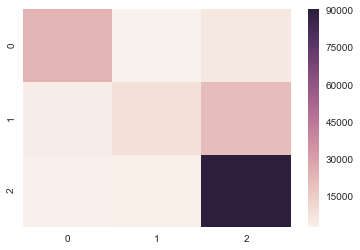

In [73]:
sns.heatmap(con_mat)

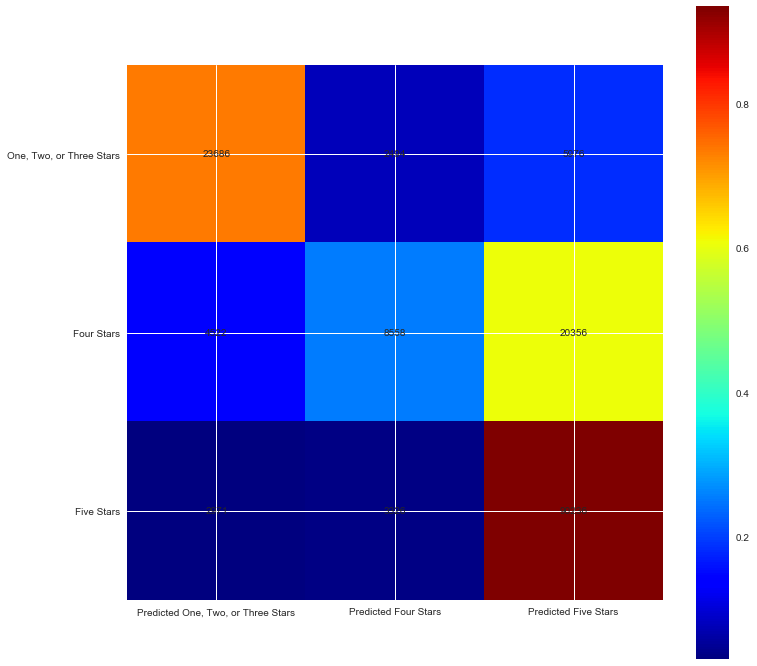

In [75]:
norm_conf = []
for i in con_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize=(12, 12))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, interpolation='nearest')

width, height = con_mat.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(con_mat[x][y]), xy=(y, x),
                   horizontalalignment='center', verticalalignment='center')

cb = fig.colorbar(res)

xlabels = ['Predicted One, Two, or Three Stars', 'Predicted Four Stars', 'Predicted Five Stars']
ylabels = ['One, Two, or Three Stars', 'Four Stars', 'Five Stars']
plt.xticks(range(width), xlabels[:width])
plt.yticks(range(height), ylabels[:height])
plt.show()

In [83]:
text_features = []
for feature in text_tfidf.get_feature_names():
    text_feature = 'text_'+feature
    text_features.append(text_feature)
    
summary_features = []
for feature in summary_tfidf.get_feature_names():
    summary_feature = 'summary_'+feature
    summary_features.append(summary_feature)

In [85]:
print(len(text_features) + len(summary_features))
print(gs_lsvc.coef_[:,:5500].shape)

5500
(1, 5500)


In [94]:
feature_coefficients = \
                        pd.DataFrame(list(zip((text_features + summary_features), 
                        gs_lsvc.coef_[:, :5500].tolist()[0])), 
                        columns=['feature', 'coefficient'])

# Saving this dataframe as a csv in case of kernel death so that the tfidf does not need to be
# run again.
feature_coefficients.to_csv('feature_coefficients.csv', index=False)

In [229]:
top20_features = feature_coefficients.reindex(feature_coefficients.coefficient.abs()
                            .sort_values(inplace=False, ascending=False).index).iloc[:20, :]

In [230]:
top20_positive_features = feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).iloc[:20, :]

In [231]:
top20_features.index = range(20)

In [232]:
top20_positive_features.index = range(20)

In [221]:
top20_features['feature'][12] = 'summary_happy'

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [233]:
top20_features

,feature,coefficient
0,text_star,-7.445050
1,text_return,-4.635802
2,text_howev,-4.087858
3,text_ok,-3.662239
4,text_unfortun,-3.643141
5,text_useless,-3.481325
6,text_unaccept,-3.230504
7,text_highli,3.194384
8,text_bewar,-3.151385
9,text_okay,-3.078618


In [234]:
top20_positive_features

,feature,coefficient
0,text_highli,3.194384
1,text_happier,2.509739
2,text_skeptic,2.424620
3,text_amaz,2.371493
4,text_deserv,2.341632
5,text_hesit,2.148273
6,text_perfectli,2.034103
7,text_gem,1.997776
8,summary_sooner,1.937179
9,text_worri,1.914985


In [224]:
top20_coefs = top20_features['coefficient'].values.tolist()

In [225]:
top20_coefs.reverse()

In [226]:
top20_words = top20_features['feature'].values.tolist()

In [227]:
top20_words.reverse()

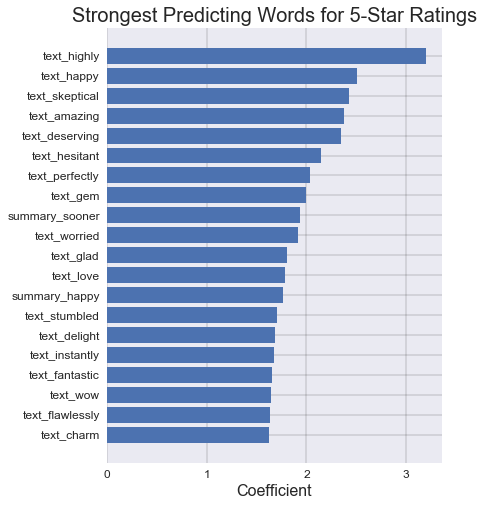

In [228]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(top20_words)), top20_coefs)
plt.title('Strongest Predicting Words for 5-Star Ratings', fontsize=20)
plt.grid(color='black', lw=0.2)
plt.xticks(np.arange(4), range(4), fontsize=12)
plt.xlabel('Coefficient', fontsize=16)
plt.yticks(np.arange(len(top20_words)), top20_words, fontsize=12)
plt.show()

In [ ]:
# high quality, expensive, sturdy, quiet, easier, bargain

# Pipeline (Work in Progress)

In [ ]:
## PIPELINE WORK IN PROGRESS!!
## WHAT IT NEEDS TO DO:
## 1. Make Two Separate Pipelines:
## 1. a) Use FeatureExtractor on 'reviewText' and 'summary'
## 1. b) Perform regex expressions on both
## 1. c) Perform Capital Ratio function (created above) on both - will need to use
##       FunctionTransformer on it before it can be used in a Pipeline
## 1. d) Perform Sentiment Analysis on both, adding a feature with the polarity of the text
## 1. e) Use TFIDF Vectorizer on both, using min_df and max_df to minimize the amount of
##       created columns
## 2. Use FeatureUnion to combine the two separate NLP pipelines
## 2. a) Use LinearSVC model on the combined features to model

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.preprocessing import FunctionTransformer

In [ ]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[[self.column]].values 

In [ ]:
text_pipe = make_pipeline(
    FeatureExtractor('reviewText'),
    FunctionTransformer(capital_ratio, validate=False),
    FunctionTransformer(polarity, validate=False),
    TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.001, max_df=0.6)
)

summary_pipe = make_pipeline(
    FeatureExtractor('summary'),
    FunctionTransformer(capital_ratio, validate=False),
    FunctionTransformer(polarity, validate=False),
    TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.01, max_df=0.6)
)

union = make_union(
    text_pipe,
    summary_pipe
)

modeling_pipe = make_pipeline(
    union,
    LinearSVC()
)

In [ ]:
modeling_pipe.fit(X_train, y_train)